# k-means Clustering

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as pty
import plotly.graph_objs as ptygo
import plotly.grid_objs as ptygr

pty.init_notebook_mode(connected=True)

plt.rcParams.update({
    'figure.figsize': (20, 10),
    'axes.grid': True,
    'font.size': 15,
})

First, we load the data and delete the unnecessary index column.

In [3]:
data = pd.read_csv('faithful.csv', delim_whitespace=True)
del data['i']
data.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


For visualization, we plot the data as scatter plot.

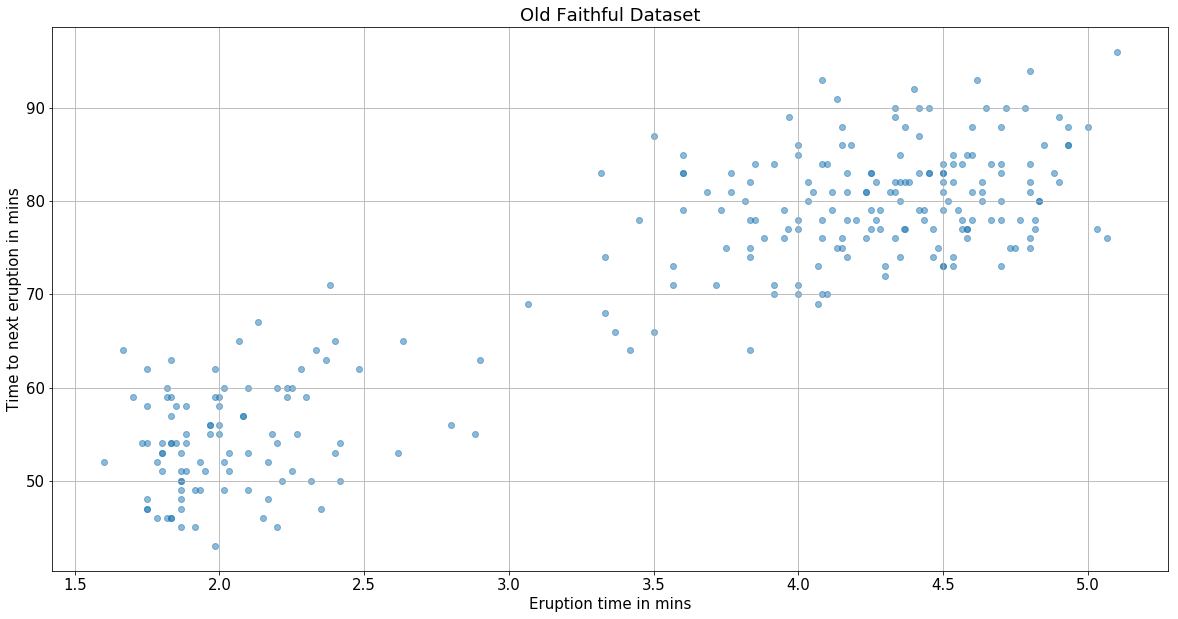

In [4]:
plt.figure(1)
plt.scatter(data['eruptions'], data['waiting'], marker='o', alpha=0.5)
plt.xlabel('Eruption time in mins')
plt.ylabel('Time to next eruption in mins')
plt.title('Old Faithful Dataset')
plt.show()

Because of the different scaling in the axes, we apply a min-max normalization to all axes. This brings all the dimensions to a range of [0, 1].

In [5]:
ndata = (data - data.min()) / (data.max() - data.min())
ndata.head()

,eruptions,waiting
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453


We now plot the normalized data, just for the sake of curiosity. We can see from the similar shape that no information is lost or added due to normalization.

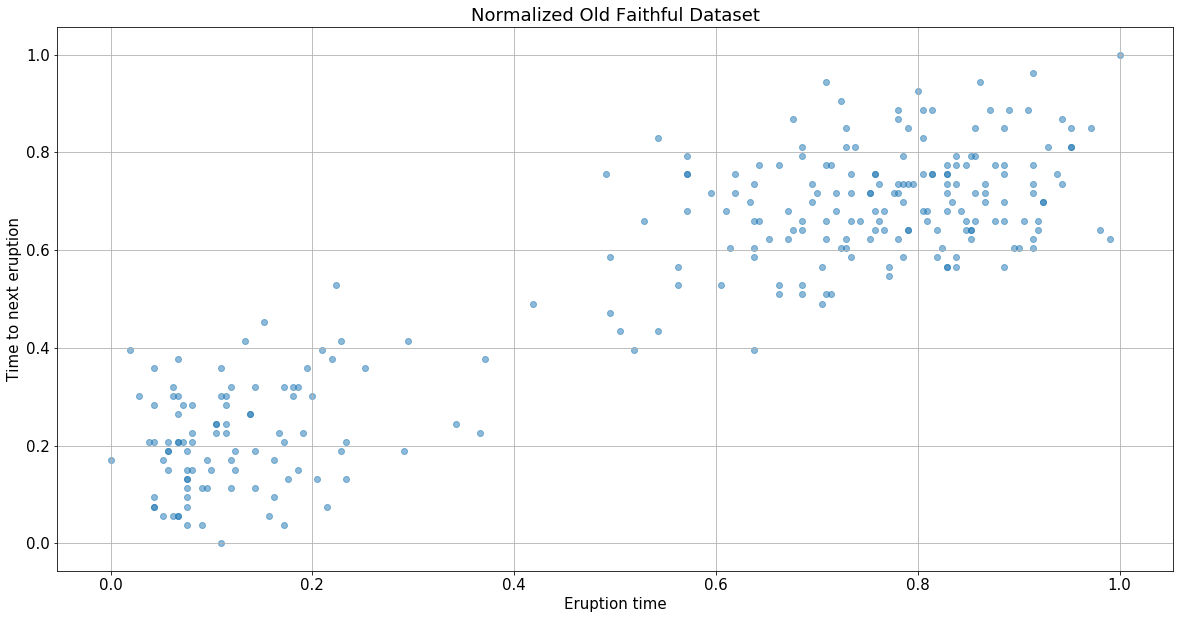

In [6]:
plt.figure(1)
plt.scatter(ndata['eruptions'], ndata['waiting'], marker='o', alpha=0.5)
plt.xlabel('Eruption time')
plt.ylabel('Time to next eruption')
plt.title('Normalized Old Faithful Dataset')
plt.show()

We now define the basic k-means algorithm. This is pretty straight-forward and just implements the mathematical operations from the lecture. This also calculates the WSS value for the given `k`.

In [7]:
def kmeans(k, data):
    m = np.random.uniform(0, 1, (k, 2))
    m_prev = np.zeros(m.shape)
    labels = np.zeros(data.shape[0])
    wss = np.zeros(k)
    
    dist = np.linalg.norm(m - m_prev, None)
    
    while dist > 0:
        labels = np.apply_along_axis(lambda x: np.argmin(np.linalg.norm(np.array(x) - m, axis=1)), 1, np.array(data))
        
        m_prev = m.copy()
        
        for i in range(k):
            p = [data.iloc[j] for j in range(data.shape[0]) if labels[j] == i]
            
            if len(p) > 0:
                m[i] = np.mean(p, axis=0)
        
        dist = np.linalg.norm(m - m_prev, None)
    
    for i in range(k):
        p = [data.iloc[j] for j in range(data.shape[0]) if labels[j] == i]
        
        if len(p) > 0:
            wss[i] = np.sum(np.square(np.linalg.norm(np.array(p) - m[i], axis=1)))
    
    return labels, m, np.sum(wss)

To visualize the clustering, we chose different colors. The calculated cluster centers are plottet with a larger, grey dot.

In [8]:
def plot_kmeans(k, data):
    labels, centers, wss = kmeans(k, data)
    colors = ['y', 'b', 'g', 'r', 'c', 'm']
    plt.figure(1)

    for i in range(k):
        p = np.array([data.iloc[j] for j in range(data.shape[0]) if labels[j] == i])

        if len(p) > 0:
            plt.gca().scatter(p[:, 0], p[:, 1], marker='o', alpha=0.5, c=colors[i])

    plt.gca().scatter(centers[:, 0], centers[:, 1], marker='o', alpha=0.5, s=150, c='k')
    plt.xlabel('Eruption time')
    plt.ylabel('Time to next eruption')
    plt.title('Clustered, normalized Old Faithful Dataset')
    plt.show()

Now do the k-means clustering with a k of 2. We know intuitivly, that `k = 2` seems to be the best fitting solution, because we can see more or less two cluster right from the first plot in the beginning.

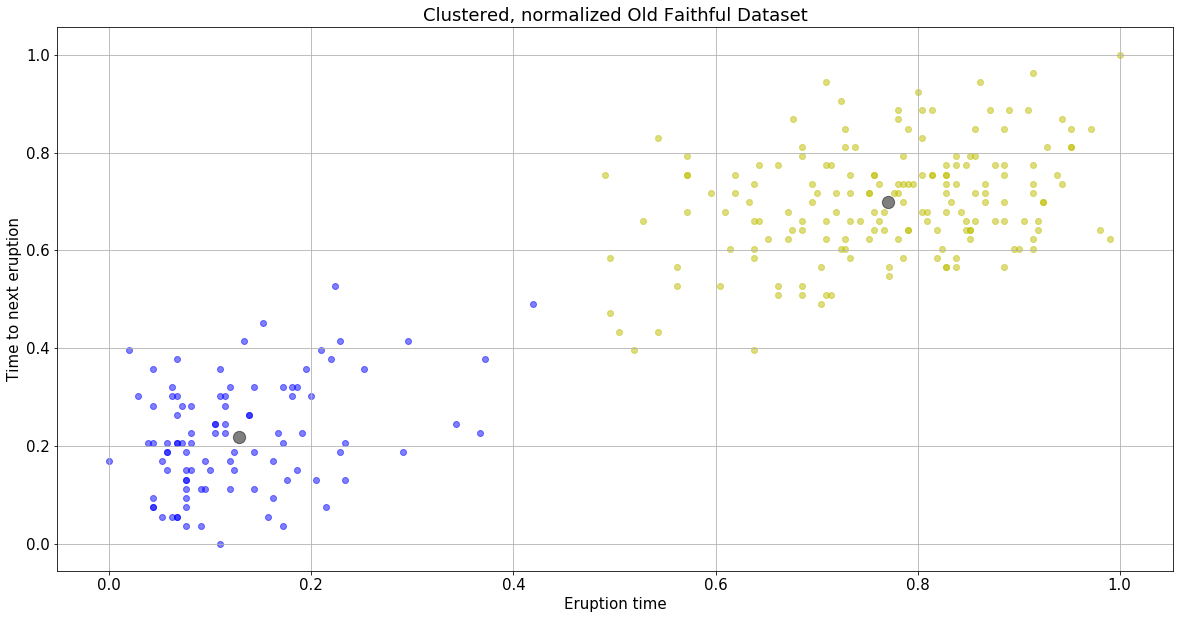

In [9]:
plot_kmeans(2, ndata)

Again, for the sake of cuiousity, we chose to plot the clustering with `k = 5`. You can see that this value is definitly not fitting for the given data set. Clusters are split into smaller clusters, where one big cluster would be the better solution. Also, outliner clusters are generated, which don't even have assigned data points.

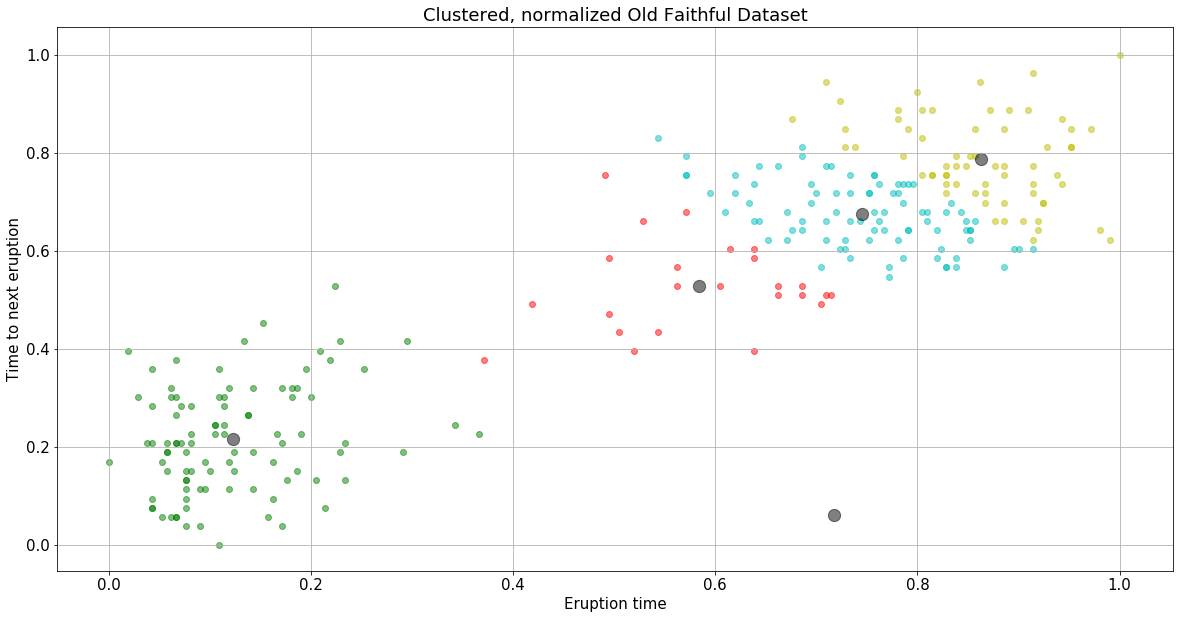

In [10]:
plot_kmeans(5, ndata)

Now plot the WSS values for k in the range of [1, 10]. The graph shows the intuitivly chosen value of 2 for k was indeed the right choice. The graph shows a distinct break for `k = 2`, which confirmed the assumption.

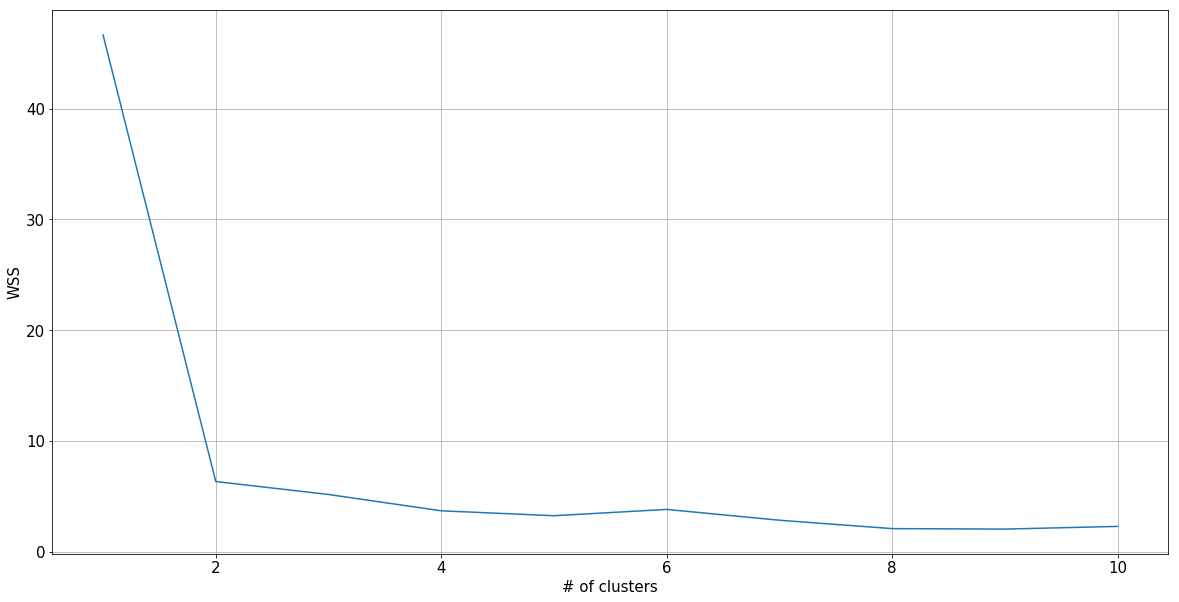

In [11]:
wss = np.zeros(10)

for i in range(1, 11):
    wss[i - 1] = kmeans(i, ndata)[2]

plt.figure(1)
plt.plot(range(1, 11), wss)
plt.xlabel('# of clusters')
plt.ylabel('WSS')
plt.show()

In [12]:
def animate_kmeans(k, data):
    m = np.random.uniform(0, 1, (k, 2))
    m_prev = np.zeros(m.shape)
    labels = np.zeros(data.shape[0])
    wss = np.zeros(k)
    
    dist = np.linalg.norm(m - m_prev, None)
    
    frames = []
    columnsNew = {}
    
    labelsHist = []
    
    z = 0
    
    for i in range(k):
        p = np.array([data.iloc[j] for j in range(data.shape[0]) if labels[j] == i])

        if len(p) > 0:
            m[i] = np.mean(p, axis=0)

            columnsNew['pointX_{:d}'.format(i)] = np.array(p[:, 0], copy=True)
            columnsNew['pointY_{:d}'.format(i)] = np.array(p[:, 1], copy=True)
        else:
            columnsNew['pointX_{:d}'.format(i)] = np.array([], copy=True)
            columnsNew['pointY_{:d}'.format(i)] = np.array([], copy=True)
            
    columnsNew['centerX'] = np.array(m[:, 0], copy=True)
    columnsNew['centerY'] = np.array(m[:, 1], copy=True)
    
    while dist > 0:
        labels = np.apply_along_axis(lambda x: np.argmin(np.linalg.norm(np.array(x) - m, axis=1)), 1, np.array(data))
        
        labelsHist.append(np.array(labels, copy=True))

        columnsNew['centerX_{:d}'.format(z)] = np.array(m[:, 0], copy=True)
        columnsNew['centerY_{:d}'.format(z)] = np.array(m[:, 1], copy=True)
        
        m_prev = m.copy()
        
        for i in range(k):
            p = np.array([data.iloc[j] for j in range(data.shape[0]) if labels[j] == i])
            
            if len(p) > 0:
                m[i] = np.mean(p, axis=0)
                
                columnsNew['pointX_{:d}_{:d}'.format(i, z)] = np.array(p[:, 0], copy=True)
                columnsNew['pointY_{:d}_{:d}'.format(i, z)] = np.array(p[:, 1], copy=True)
            else:
                columnsNew['pointX_{:d}_{:d}'.format(i, z)] = np.array([], copy=True)
                columnsNew['pointY_{:d}_{:d}'.format(i, z)] = np.array([], copy=True)
        
        dist = np.linalg.norm(m - m_prev, None)
        
        z = z + 1
    
    colors = [
        ptygo.Marker(color='yellow', size=10, opacity=0.5),
        ptygo.Marker(color='blue', size=10, opacity=0.5),
        ptygo.Marker(color='green', size=10, opacity=0.5),
        ptygo.Marker(color='red', size=10, opacity=0.5),
        ptygo.Marker(color='cyan', size=10, opacity=0.5),
        ptygo.Marker(color='magenta', size=10, opacity=0.5),
    ]
    
    colorscale = [
        [0.0, 'rgb(255, 0, 0)'],
        [0.2, 'rgb(255, 0, 0)'],
        
        [0.2, 'rgb(0, 0, 255)'],
        [0.4, 'rgb(0, 0, 255)'],
        
        [0.4, 'rgb(0, 255, 0)'],
        [0.6, 'rgb(0, 255, 0)'],
        
        [0.6, 'rgb(255, 0, 255)'],
        [0.8, 'rgb(255, 0, 255)'],
        
        [0.8, 'rgb(0, 255, 255)'],
        [1.0, 'rgb(0, 255, 255)'],
    ]
    
    for j in range(z):
        dataArray = [
            ptygo.Scatter(**{
                'x': data.iloc[:, 0],
                'y': data.iloc[:, 1],
                'mode': 'markers',
                'marker': ptygo.Marker(
                    size=6,
                    opacity=0.5,
                    cmin=0,
                    cmax=k,
                    color=labelsHist[j],
                    colorscale=colorscale,
                )
            }),
            ptygo.Scatter(**{
                'x': columnsNew['centerX_{:d}'.format(j)],
                'y': columnsNew['centerY_{:d}'.format(j)],
                'mode': 'markers',
                'marker': ptygo.Marker(color='black', size=10, opacity=0.7),
            }),
        ]
        
        frames.append({
            'data': dataArray,
        })
        
    dataArray = [
        ptygo.Scatter(**{
            'x': data.iloc[:, 0],
            'y': data.iloc[:, 1],
            'mode': 'markers',
            'marker': ptygo.Marker(
                size=6,
                opacity=0.5,
                cmin=0,
                cmax=k,
                color=np.zeros(data.shape[0]),
                colorscale=colorscale,
            )
        }),
        ptygo.Scatter(**{
            'x': columnsNew['centerX'],
            'y': columnsNew['centerY'],
            'mode': 'markers',
            'marker': ptygo.Marker(color='black', size=10, opacity=0.7),
        }),
    ]
    
    figure = {
        'data': dataArray,
        'layout': {
            'xaxis': {
                'range': [-0.1, 1.2],
                'autorange': False,
            },
            'yaxis': {
                'range': [-0.1, 1.2],
                'autorange': False,
            },
            'margin': {
                'l': 0,
                'r': 0,
                't': 0,
                'pad': 4,
            },
            'updatemenus': [
                {
                    'buttons': [
                        {
                            'args': [None],
                            'label': 'Play',
                            'method': 'animate',
                        },
                    ],
                    'pad': {
                        'r': 10,
                        't': 87,
                    },
                    'type': 'buttons',
                },
            ],
            'showlegend': False,
        },
        'frames': frames,
    }
    
    pty.iplot(figure, show_link=False)

In [13]:
animate_kmeans(2, ndata)

In [14]:
animate_kmeans(5, ndata)